## Predicting Mortality Risk of ICU patients Post-CABG

#### RNN Model

## Setting up environment and loading data

In [4]:
!pip install deepecho

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for deepecho from https://files.pythonhosted.org/packages/49/e8/f5ffe968c62ea5ec13330bff21e8773fa07b79df803003033274daccd0bf/deepecho-0.6.1-py3-none-any.whl.metadata
  Using cached deepecho-0.6.1-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for torch>=1.11.0 from https://files.pythonhosted.org/packages/2a/ef/834af4a885b31a0b32fff2d80e1e40f771e1566ea8ded55347502440786a/torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/b9/f8/feced7779d755758a52d1f6635d990b8d98dc0a29fa568bbe0625f18fdf3/filelock-3.16.1-py3-none-any.whl.metadata
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9f

In [6]:
!pip install sdv

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for sdv from https://files.pythonhosted.org/packages/03/14/0d59ca94430436143556f88d48fa569d71b7e1a1df53c09e90d8d5f7142e/sdv-1.17.2-py3-none-any.whl.metadata
  Obtaining dependency information for boto3<2.0.0,>=1.28 from https://files.pythonhosted.org/packages/ce/4c/f705301ad8463375c137eefc9cbddd23ee1a6681e9db0fc3cb8ae7ba8426/boto3-1.35.68-py3-none-any.whl.metadata
  Obtaining dependency information for botocore<2.0.0,>=1.31 from https://files.pythonhosted.org/packages/c7/20/9c8b7112a7f76d819e09ad2964d0e4211bcde23e41feb0e1e92dd8b89051/botocore-1.35.68-py3-none-any.whl.metadata
  Obtaining dependency information for graphviz>=0.13.2 from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
  Obtaining dependency information for copulas>=0.12.0 from https://files.pythonhosted.org/pac

In [2]:
import deepecho
from sdv.sequential import PARSynthesizer
from sdv.metadata import Metadata

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
import keras_tuner as kt
from keras_tuner import HyperParameters, RandomSearch, Objective

2024-12-09 17:12:12.559237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 17:12:12.922330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 17:12:13.102017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 17:12:13.964607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for imblearn from https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl.metadata
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/d8/0d/c3bfccc5d460eec8ff56889802aa88f5d07280d5282b307a74558e6edc44/imbalanced_learn-0.12.4-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)


In [4]:
from imblearn.over_sampling import SMOTENC

In [5]:
# Set working directory
os.chdir('/sfs/gpfs/tardis/home/rmd9ev/Documents/MSDS/DS6050/Project/')

# Verifying GPU availability
print(tf.config.list_physical_devices('GPU'))

# Verifying tensorflow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.17.0


In [6]:
from os import listdir

# Data path for complete data
data_path1 = "/sfs/gpfs/tardis/home/rmd9ev/Documents/MSDS/DS6050/Project/final_data_complete"

# Files to read
data_files1 = listdir(data_path1)

# Load data
complete_final_df = pd.concat([pd.read_csv(data_path1 + '/' + file) for file in data_files1[1:]])


#Set data path for imputed data
data_path2 = "/sfs/gpfs/tardis/home/rmd9ev/Documents/MSDS/DS6050/Project/final_data_imputed"

# Files to read
data_files2 = listdir(data_path2)

# Load data
imputed_final_df = pd.concat([pd.read_csv(data_path2 + '/' + file) for file in data_files2[1:]])

In [14]:
len(imputed_final_df['stay_id'].unique())

3048

## Model Building

In [7]:
import random
# Ensure reproducibility by setting random seeds
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [8]:
# Creating F1 score class
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [9]:
# Create class to preprocess data
class preprocessor:
    def __init__(self, pad_length=156, seed = 42):
            # Set global seeds
        np.random.seed(seed)
        tf.random.set_seed(seed)
        keras.utils.set_random_seed(seed)
        
        # Enable deterministic operations
        tf.config.experimental.enable_op_determinism()

        self.pad_length = pad_length
        self.label_encoders = {}
        self.numerical_scaler = StandardScaler()
        self.numerical_columns = ["anchor_age", "map", "hr", "pao2", "fio2", "gcs", "charlson",
                                "creatinine", "lactate", "platelets", "epinephrine", 
                                "norepinephrine", "phenylephrine", "dobutamine", 
                                "milrinone", "dopamine"]
        self.categorical_columns = ['insurance', 'gender', 'race', 'marital_status']
        self.binary_columns = ['vent']
        self.outcome = ['mortality']

    def fit(self, df):
        """Fit preprocessor on training data"""
        # Initialize and fit label encoders for categorical columns
        for col in self.categorical_columns:
            self.label_encoders[col] = LabelEncoder()
            self.label_encoders[col].fit(df[col].astype(str))
        
        # Fit scaler on numerical columns (reshaping for time series)
        numerical_data = df[self.numerical_columns].values
        self.numerical_scaler.fit(numerical_data)
                
        return self

    def transform(self, df):
        """Transform the data using fitted preprocessors"""
        # Transform categorical columns
        transformed_categorical = df[self.categorical_columns].copy()
        for col in self.categorical_columns:
            transformed_categorical[col] = self.label_encoders[col].transform(df[col].astype(str))

        # Stay ID
        stay_id = df['stay_id'].copy()
        
        # Scale numerical columns
        transformed_numerical = pd.DataFrame(
            self.numerical_scaler.transform(df[self.numerical_columns]),
            columns=self.numerical_columns
        )

        # Binary columns are used as-is (no transformation)
        transformed_binary = df[self.binary_columns].astype(int)
        transformed_outcome = df[self.outcome].astype(int)
        
        #reseting indexes so they are unique - needed to add this
        stay_id = stay_id.reset_index(drop=True)
        transformed_binary = transformed_binary.reset_index(drop=True)
        transformed_outcome = transformed_outcome.reset_index(drop=True)
        transformed_categorical = transformed_categorical.reset_index(drop=True)
        
        # Concatenate data
        transformed_data = pd.concat([stay_id, transformed_categorical, transformed_numerical, transformed_binary, transformed_outcome], axis=1)
        self.transformed_data = transformed_data
        
        # Combine transformed categorical, numerical, and binary columns
        return transformed_data

    def vectorization(self):
        """Convert transformed data to sequence vectors"""
        # Create sequences
        self.sequence_data = []
        self.sequence_labels = []
        
        for stay in self.transformed_data['stay_id'].unique():
            stay_data = self.transformed_data[self.transformed_data['stay_id'] == stay]
            features = stay_data[self.numerical_columns + self.categorical_columns + self.binary_columns].values
            label = stay_data[self.outcome].values[-1]
            
            self.sequence_data.append(features)
            self.sequence_labels.append(label)
        
        # Pad sequences
        self.sequence_data = keras.preprocessing.sequence.pad_sequences(
            self.sequence_data, 
            padding='post',
            maxlen=self.pad_length,
            value=-99
        )

        self.sequence_labels = np.array(self.sequence_labels)
        
        return self

    def train_test_split(self, size = 0.8):    #added train, validation, and test and stratified
        """Split data into training testing"""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.sequence_data, self.sequence_labels, stratify =self.sequence_labels, test_size=0.2, random_state=42)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, stratify = self.y_train, test_size=0.2, random_state = 42) 
        return self
        

    def Dataset(self, batch_size = 64):
        """Create dataset object"""
        train_df = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train))
        train_df = (
            train_df
            .shuffle(buffer_size=len(self.X_train))        # Shuffle the entire dataset in memory
            .batch(batch_size)                        # Batch the data
            .prefetch(buffer_size=tf.data.AUTOTUNE)   # Prefetch batches for performance
        )
        
        val_df = tf.data.Dataset.from_tensor_slices((self.X_val, self.y_val))
        val_df = (
            val_df
            .batch(batch_size)                        # Batch the data
            .prefetch(buffer_size=tf.data.AUTOTUNE)   # Prefetch batches for performance
        )
        
        test_df = tf.data.Dataset.from_tensor_slices((self.X_test, self.y_test))
        test_df = (
            test_df
            .batch(batch_size)                        # Batch the data
            .prefetch(buffer_size=tf.data.AUTOTUNE)   # Prefetch batches for performance
        )
        
        return train_df, val_df, test_df


### Using Complete data

In [10]:
preprocess = preprocessor()

# Encoding data
preprocess.fit(complete_final_df)
data = preprocess.transform(complete_final_df)

# Vectorization
preprocess.vectorization()

# Splitting train/test
preprocess.train_test_split()

# Creating datasets
train, val, test = preprocess.Dataset()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
2024-12-09 17:12:42.092983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46845 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
# Extract the shape of the input data from the Dataset
for X_batch, _ in train.take(1):
    input_shape = X_batch.shape[1:]  # Exclude the batch dimension
    break

In [242]:
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, class_weight=None, seed = 42):
        # Set global seeds
        np.random.seed(seed)
        tf.random.set_seed(seed)
        keras.utils.set_random_seed(seed)
        # Enable deterministic operations
        tf.config.experimental.enable_op_determinism()

        self.seed = seed
        self.model = None
        self.best_hp = None
        self.classes_ = np.array([0, 1])  # Binary classification
        self.tuner = None
        self.class_weight = class_weight  # Store class weights
        self.callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
    )
]

    def create_model(self, hp):
        """Create the model with optional hyperparameters."""
        # Define hyperparameters
        hp_dropout = hp.Choice('dropout_rate', [0.2, 0.3, 0.4, 0.5])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Add seed to layer initialization
        initializer = tf.keras.initializers.GlorotUniform(seed=self.seed)
        
        # Defining model architecture
        model = keras.models.Sequential([
            keras.layers.InputLayer(shape=((input_shape[0],input_shape[1]))),
            keras.layers.Masking(mask_value= -99),  # for variable-length sequences
            keras.layers.SimpleRNN(32,dropout=hp_dropout,
                                   activation = 'tanh',
                                   use_bias = True, 
                                   kernel_initializer = initializer,
                                   recurrent_initializer = initializer,
                                   kernel_regularizer= keras.regularizers.l2(1e-9),
                                   bias_regularizer = keras.regularizers.l2(1e-9)),
            keras.layers.Dense(1, activation='sigmoid')
        
        ])  
        # Defining metrics
        metrics = [
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc'),
            AUC(name='auprc', curve='PR'),
            F1Score(name='f1_score'),
        ]

        # Use binary cross-entropy with logits
        loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Compiling model
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                     loss= loss_fn, 
                     metrics=metrics)
        return model

    def compute_class_weight(self, df):
        """
        Compute class weights automatically if not provided
        
        Args:
            train: TensorFlow dataset
        
        Returns:
            dict: Class weights
        """
        # Extract labels from the dataset
        #y_true = np.array([label.numpy() for _, label in df])
        y_true = np.concatenate([label.numpy().flatten() for _, label in df], axis=0)

        # Compute class distribution
        unique, counts = np.unique(y_true, return_counts=True)
        total_samples = len(y_true)
        
        # Compute balanced class weights
        class_weights = {
            0: total_samples / (2 * counts[0]),
            1: total_samples / (2 * counts[1])
        }
        
        return class_weights
    
    def tune(self, train, validation):
        """Hyperparameter fine tuning using random grid search"""
        # Automatically compute class weights if not provided
        if self.class_weight is None:
            self.class_weight = self.compute_class_weight(train)

        def build_model(hp):
            return self.create_model(hp)
        
        tuner = RandomSearch(
            build_model,
            objective=Objective("f1score", direction="max"),
            max_trials=25,
            executions_per_trial=1,
            directory='models',
            project_name='rnn_tuning_2',
            seed = 42
        )
    
        tuner.search(
            train,
            validation_data=validation,
            epochs=20,
            callbacks=self.callbacks,
            class_weight=self.class_weight  # Add class weights to search
        )
    
        # Save the best hyperparameters and model
        self.best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        self.model = tuner.get_best_models(num_models=1)[0]
        self.tuner = tuner
    
        return self.best_hp, self.model

    def retrain_best_model(self, train, validation):
        """Retrain the best model to obtain its training history."""
        if self.best_hp is None:
            raise ValueError("No hyperparameters tuned yet. Please run tune().")

        # Automatically compute class weights if not provided
        if self.class_weight is None:
            self.class_weight = self.compute_class_weight(train)
        
        # Rebuild the best model using the best hyperparameters
        best_model = self.create_model(self.best_hp)
        
        # Retrain the model and capture the history
        history = best_model.fit(
            train,
            epochs=20,  # Adjust as needed
            validation_data=validation,
            #callbacks=self.callbacks,
            verbose=1,
            class_weight=self.class_weight
        )
        return best_model, history
    
    def predict(self, df):
        """Return predicted class labels"""
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        logits = self.model.predict(df)  # Predict probabilities
        probabilities = tf.nn.sigmoid(logits).numpy()
        return (probabilities > 0.5).astype(int).flatten()  # Convert to binary class labels (0 or 1)
    
    def predict_proba(self, df):
        """Return probability estimates for both classes (negative and positive)"""
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        logits = self.model.predict(df)  # Predict probabilities
        probabilities = tf.nn.sigmoid(logits).numpy()
        return np.hstack([1 - probabilities, probabilities])  # Class 0 and Class 1 probabilities

    # def get_best_model_metrics(self, df):
    #     """Retrieve the performance metrics of the best tuned model."""
    #     if self.model is None:
    #         raise ValueError("No model has been trained or tuned yet.")
        
    #     # Evaluate the model
    #     metrics = self.model.evaluate(df, verbose=0)
    
    #     # Format metrics as a dictionary
    #     return {name: value for name, value in zip(self.model.metrics_names, metrics)}
    
    def accuracy(self, df):
        """Return accuracy score"""
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        # Extract true labels
        y_true = np.array([label.numpy() for _, label in df])  # Convert from TensorFlow dataset to NumPy
        y_pred = self.predict(df)
        return accuracy_score(y_true, y_pred)

In [243]:
# Initiate Wrapper
wrapper = KerasModelWrapper()
# Fine tune the model with training and validation set
best_hp, best_model = wrapper.tune(train, val)

Reloading Tuner from models/rnn_tuning_2/tuner0.json


In [244]:
print(f"Best Hyperparameters: {best_hp.values}")
wrapper.model.summary()  # Show the best model architecture

Best Hyperparameters: {'dropout_rate': 0.2, 'learning_rate': 0.001}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 156, 21)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,761 (6.88 KB)

 Trainable params: 1,761 (6.88 KB)

 Non-trainable params: 0 (0.00 B)

In [245]:
best_model.evaluate(test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.0228 - auc: 0.4826 - auprc: 0.2236 - f1_score: 0.0269 - loss: 1.9298 - precision: 0.0136 - recall: 1.0000


[1.9259138107299805,
 0.02687140181660652,
 0.01361867692321539,
 1.0,
 0.5222345590591431,
 0.09212353080511093,
 0.026871396228671074]

In [246]:
best_model.get_metrics_result()  #training

{'accuracy': 0.02687140181660652,
 'auc': 0.5222345590591431,
 'auprc': 0.09212353080511093,
 'f1_score': 0.026871396228671074,
 'loss': 1.9259138107299805,
 'precision': 0.01361867692321539,
 'recall': 1.0}

In [247]:
top, history = wrapper.retrain_best_model(train, val)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.0744 - auc: 0.1975 - auprc: 0.0082 - f1_score: 0.0211 - loss: 0.8520 - precision: 0.0107 - recall: 0.7244 - val_accuracy: 0.8777 - val_auc: 0.5503 - val_auprc: 0.0778 - val_f1_score: 0.0727 - val_loss: 0.6106 - val_precision: 0.0408 - val_recall: 0.3333
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8510 - auc: 0.5504 - auprc: 0.0417 - f1_score: 0.0723 - loss: 0.6436 - precision: 0.0396 - recall: 0.4398 - val_accuracy: 0.9664 - val_auc: 0.7350 - val_auprc: 0.1285 - val_f1_score: 0.2222 - val_loss: 0.4313 - val_precision: 0.1667 - val_recall: 0.3333
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9120 - auc: 0.6983 - auprc: 0.1046 - f1_score: 0.1203 - loss: 0.5560 - precision: 0.0696 - recall: 0.4726 - val_accuracy: 0.9520 - val_auc: 0.8139 - val_auprc: 0.1357 - val_f1_score: 0.2308 - val_loss: 0.4190 - val_precision: 0.1500 - val_recall: 0.5000
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1

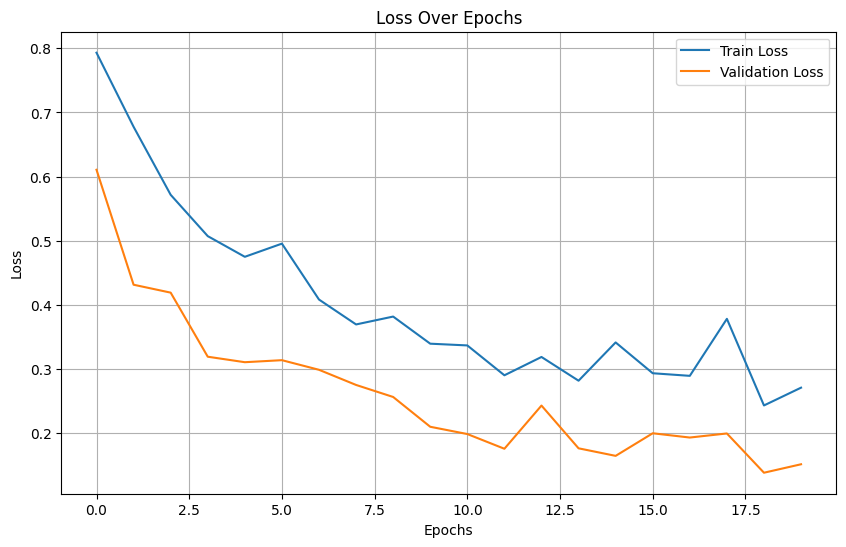

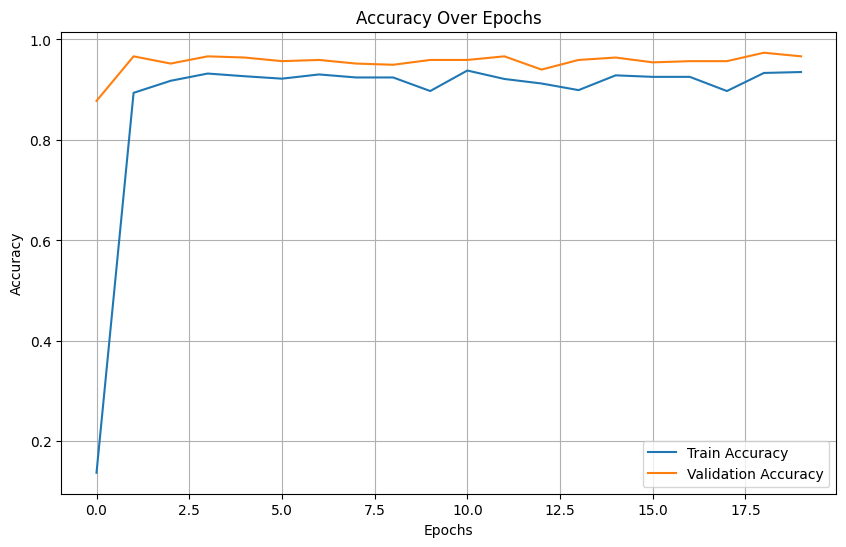

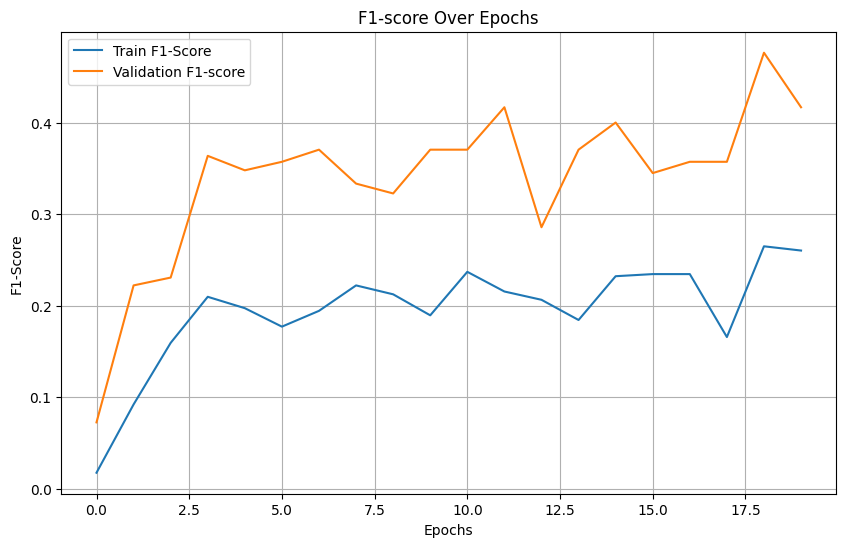

In [248]:
import matplotlib.pyplot as plt

# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Additional plots for other metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['f1_score'], label='Train F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-score Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [249]:
top.evaluate(test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9733 - auc: 0.9787 - auprc: 0.6104 - f1_score: 0.4952 - loss: 0.1542 - precision: 0.3357 - recall: 0.9571


[0.154790997505188,
 0.9750480055809021,
 0.3333333432674408,
 0.8571428656578064,
 0.9496943354606628,
 0.5916736125946045,
 0.47999998927116394]

In [250]:
top.get_metrics_result()

{'accuracy': 0.9750480055809021,
 'auc': 0.9496943354606628,
 'auprc': 0.5916736125946045,
 'f1_score': 0.47999998927116394,
 'loss': 0.154790997505188,
 'precision': 0.3333333432674408,
 'recall': 0.8571428656578064}

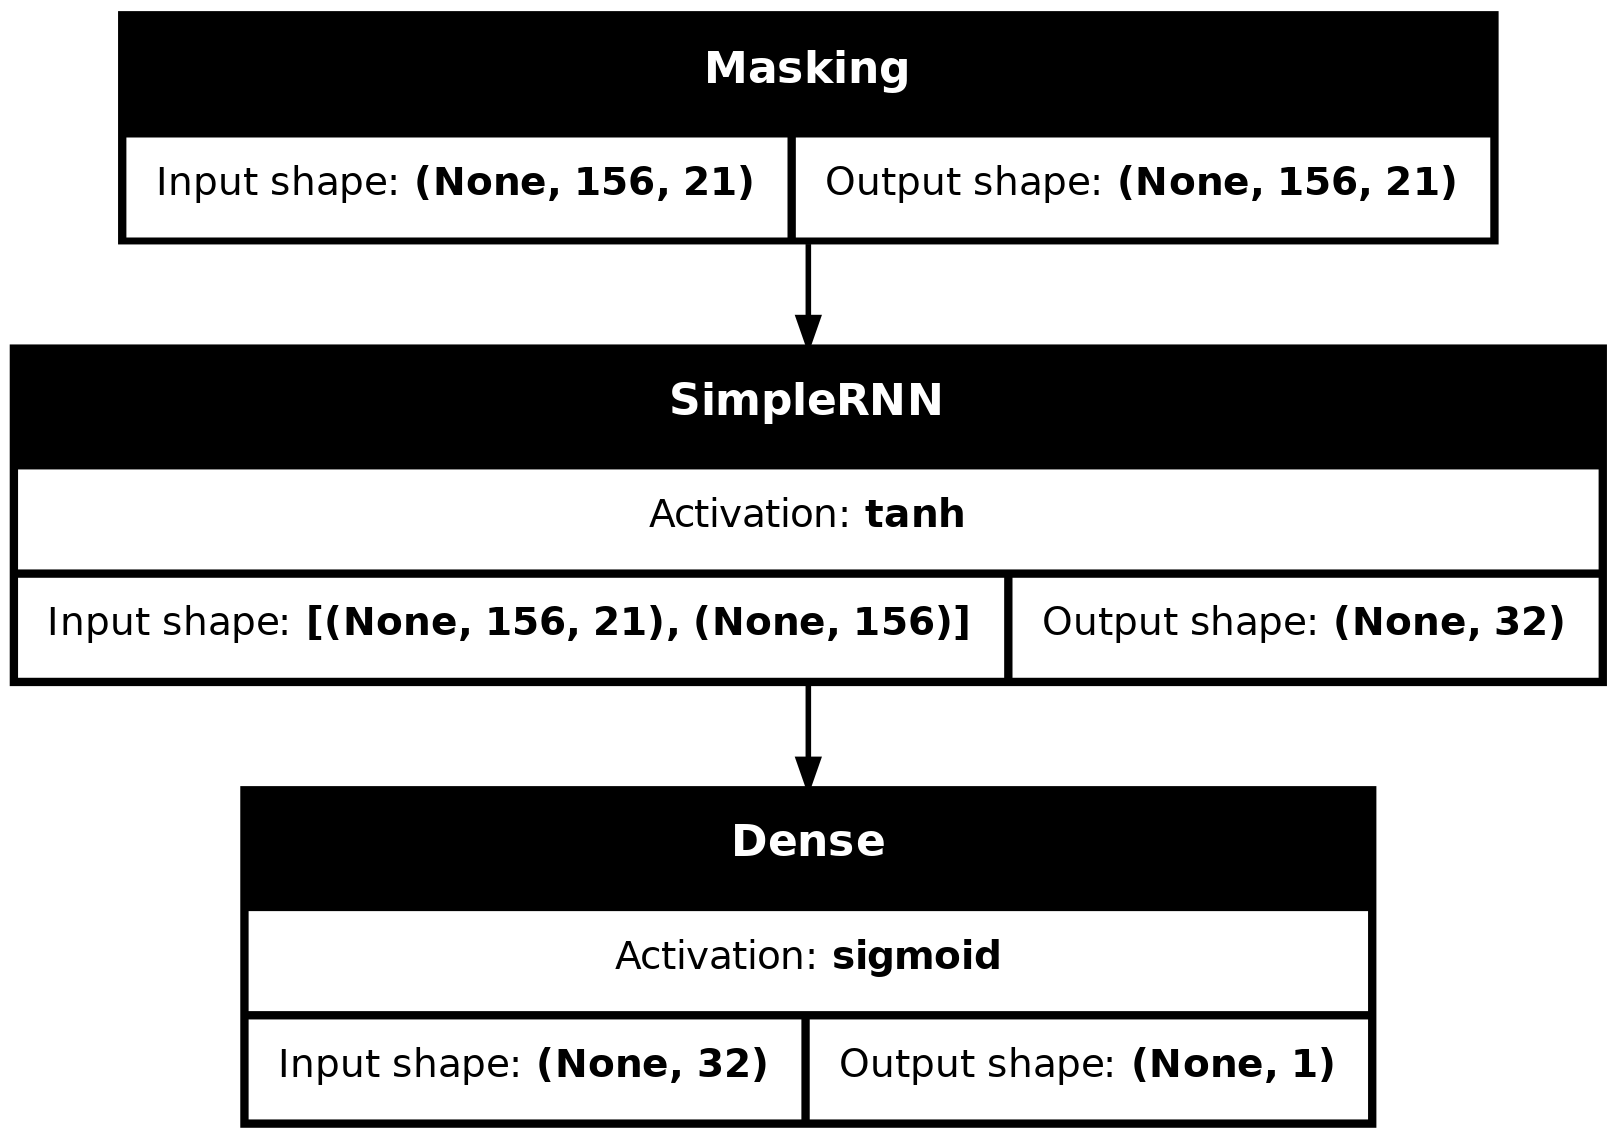

In [255]:
# import the necessary packages
from tensorflow.keras.utils import plot_model


initializer = tf.keras.initializers.GlorotUniform(seed=42)

model = keras.models.Sequential([
            keras.layers.InputLayer(shape=((input_shape[0],input_shape[1]))),
            keras.layers.Masking(mask_value= -99),  # for variable-length sequences
            keras.layers.SimpleRNN(32,dropout=0.2,
                                   activation = 'tanh',
                                   use_bias = True, 
                                   kernel_initializer = initializer,
                                   recurrent_initializer = initializer,
                                   kernel_regularizer= keras.regularizers.l2(1e-9),
                                   bias_regularizer = keras.regularizers.l2(1e-9)),
            keras.layers.Dense(1, activation='sigmoid')
        
        ])
plot_model(model, to_file="RNN.png", show_shapes=True, show_layer_activations=True)

### Using Imputed Dataset

In [268]:
preprocess = preprocessor()

# Encoding data
preprocess.fit(imputed_final_df)
data = preprocess.transform(imputed_final_df)

# Vectorization
preprocess.vectorization()

# Splitting train/test
preprocess.train_test_split()

# Creating datasets
train, val, test = preprocess.Dataset()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [269]:
# Extract the shape of the input data from the Dataset
for X_batch, _ in train.take(1):
    input_shape = X_batch.shape[1:]  # Exclude the batch dimension
    break

In [270]:
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, class_weight=None, seed = 42):
        # Set global seeds
        np.random.seed(seed)
        tf.random.set_seed(seed)
        keras.utils.set_random_seed(seed)
        # Enable deterministic operations
        tf.config.experimental.enable_op_determinism()

        self.seed = seed
        self.model = None
        self.best_hp = None
        self.classes_ = np.array([0, 1])  # Binary classification
        self.tuner = None
        self.class_weight = class_weight  # Store class weights
        self.callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
    )
]

    def create_model(self, hp):
        """Create the model with optional hyperparameters."""
        # Define hyperparameters
        hp_dropout = hp.Choice('dropout_rate', [0.2, 0.3, 0.4, 0.5])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Add seed to layer initialization
        initializer = tf.keras.initializers.GlorotUniform(seed=self.seed)
        
        # Defining model architecture
        model = keras.models.Sequential([
            keras.layers.InputLayer(shape=((input_shape[0],input_shape[1]))),
            keras.layers.Masking(mask_value= -99),  # for variable-length sequences
            keras.layers.SimpleRNN(32,dropout=hp_dropout,
                                   activation = 'tanh',
                                   use_bias = True, 
                                   kernel_initializer = initializer,
                                   recurrent_initializer = initializer,
                                   kernel_regularizer= keras.regularizers.l2(1e-9),
                                   bias_regularizer = keras.regularizers.l2(1e-9)),
            keras.layers.Dense(1, activation='sigmoid')
        
        ])  
        # Defining metrics
        metrics = [
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc'),
            AUC(name='auprc', curve='PR'),
            F1Score(name='f1_score'),
        ]

        # Use binary cross-entropy with logits
        loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Compiling model
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                     loss= loss_fn, 
                     metrics=metrics)
        return model

    def compute_class_weight(self, df):
        """
        Compute class weights automatically if not provided
        
        Args:
            train: TensorFlow dataset
        
        Returns:
            dict: Class weights
        """
        # Extract labels from the dataset
        #y_true = np.array([label.numpy() for _, label in df])
        y_true = np.concatenate([label.numpy().flatten() for _, label in df], axis=0)

        # Compute class distribution
        unique, counts = np.unique(y_true, return_counts=True)
        total_samples = len(y_true)
        
        # Compute balanced class weights
        class_weights = {
            0: total_samples / (2 * counts[0]),
            1: total_samples / (2 * counts[1])
        }
        
        return class_weights
    
    def tune(self, train, validation):
        """Hyperparameter fine tuning using random grid search"""
        # Automatically compute class weights if not provided
        if self.class_weight is None:
            self.class_weight = self.compute_class_weight(train)

        def build_model(hp):
            return self.create_model(hp)
        
        tuner = RandomSearch(
            build_model,
            objective=Objective("f1score", direction="max"),
            max_trials=25,
            executions_per_trial=1,
            directory='models',
            project_name='rnn_tuning_2',
            seed = 42
        )
    
        tuner.search(
            train,
            validation_data=validation,
            epochs=20,
            callbacks=self.callbacks,
            class_weight=self.class_weight  # Add class weights to search
        )
    
        # Save the best hyperparameters and model
        self.best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        self.model = tuner.get_best_models(num_models=1)[0]
        self.tuner = tuner
    
        return self.best_hp, self.model

    def retrain_best_model(self, train, validation):
        """Retrain the best model to obtain its training history."""
        if self.best_hp is None:
            raise ValueError("No hyperparameters tuned yet. Please run tune().")

        # Automatically compute class weights if not provided
        if self.class_weight is None:
            self.class_weight = self.compute_class_weight(train)
        
        # Rebuild the best model using the best hyperparameters
        best_model = self.create_model(self.best_hp)
        
        # Retrain the model and capture the history
        history = best_model.fit(
            train,
            epochs=20,  # Adjust as needed
            validation_data=validation,
            #callbacks=self.callbacks,
            verbose=1,
            class_weight=self.class_weight
        )
        return best_model, history
    
    def predict(self, df):
        """Return predicted class labels"""
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        logits = self.model.predict(df)  # Predict probabilities
        probabilities = tf.nn.sigmoid(logits).numpy()
        return (probabilities > 0.5).astype(int).flatten()  # Convert to binary class labels (0 or 1)
    
    def predict_proba(self, df):
        """Return probability estimates for both classes (negative and positive)"""
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        logits = self.model.predict(df)  # Predict probabilities
        probabilities = tf.nn.sigmoid(logits).numpy()
        return np.hstack([1 - probabilities, probabilities])  # Class 0 and Class 1 probabilities

    # def get_best_model_metrics(self, df):
    #     """Retrieve the performance metrics of the best tuned model."""
    #     if self.model is None:
    #         raise ValueError("No model has been trained or tuned yet.")
        
    #     # Evaluate the model
    #     metrics = self.model.evaluate(df, verbose=0)
    
    #     # Format metrics as a dictionary
    #     return {name: value for name, value in zip(self.model.metrics_names, metrics)}
    
    def accuracy(self, df):
        """Return accuracy score"""
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        # Extract true labels
        y_true = np.array([label.numpy() for _, label in df])  # Convert from TensorFlow dataset to NumPy
        y_pred = self.predict(df)
        return accuracy_score(y_true, y_pred)

In [271]:
# Initiate Wrapper
wrapper = KerasModelWrapper()
# Fine tune the model with training and validation set
best_hp, best_model = wrapper.tune(train, val)

Reloading Tuner from models/rnn_tuning_2/tuner0.json


/home/rmd9ev/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [272]:
print(f"Best Hyperparameters: {best_hp.values}")
wrapper.model.summary()  # Show the best model architecture

Best Hyperparameters: {'dropout_rate': 0.2, 'learning_rate': 0.001}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 156, 21)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,761 (6.88 KB)

 Trainable params: 1,761 (6.88 KB)

 Non-trainable params: 0 (0.00 B)

In [273]:
best_model.evaluate(test)

/home/rmd9ev/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.0272 - auc: 0.7737 - auprc: 0.3476 - f1_score: 0.0324 - loss: 1.9011 - precision: 0.0165 - recall: 1.0000


[1.9123793840408325,
 0.02295081876218319,
 0.013245033100247383,
 1.0,
 0.7408638000488281,
 0.22566936910152435,
 0.026143789291381836]

In [274]:
best_model.get_metrics_result()  #training

{'accuracy': 0.02295081876218319,
 'auc': 0.7408638000488281,
 'auprc': 0.22566936910152435,
 'f1_score': 0.026143789291381836,
 'loss': 1.9123793840408325,
 'precision': 0.013245033100247383,
 'recall': 1.0}

In [275]:
top, history = wrapper.retrain_best_model(train, val)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.1466 - auc: 0.4086 - auprc: 0.0163 - f1_score: 0.0158 - loss: 0.7304 - precision: 0.0080 - recall: 0.6498 - val_accuracy: 0.8504 - val_auc: 0.3382 - val_auprc: 0.0087 - val_f1_score: 0.0000e+00 - val_loss: 0.5971 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7169 - auc: 0.4336 - auprc: 0.0287 - f1_score: 0.0262 - loss: 0.7377 - precision: 0.0137 - recall: 0.3298 - val_accuracy: 0.9262 - val_auc: 0.7649 - val_auprc: 0.0366 - val_f1_score: 0.1000 - val_loss: 0.5219 - val_precision: 0.0588 - val_recall: 0.3333
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9213 - auc: 0.6759 - auprc: 0.1702 - f1_score: 0.1396 - loss: 0.6151 - precision: 0.0810 - recall: 0.5087 - val_accuracy: 0.9549 - val_auc: 0.9321 - val_auprc: 0.1027 - val_f1_score: 0.2143 - val_loss: 0.4166 - val_precision: 0.1364 - val_recall: 0.5000
Epoch 4/20
31/31 ━━━━━━━━━━━━━

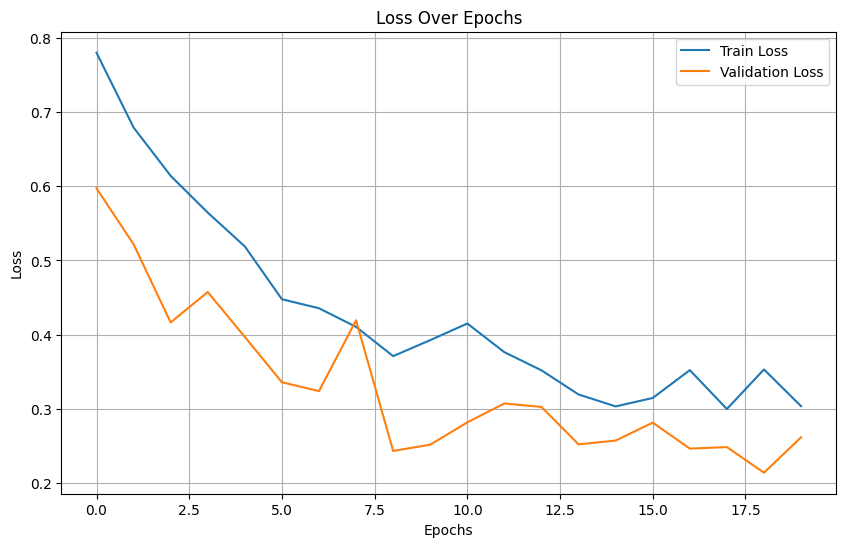

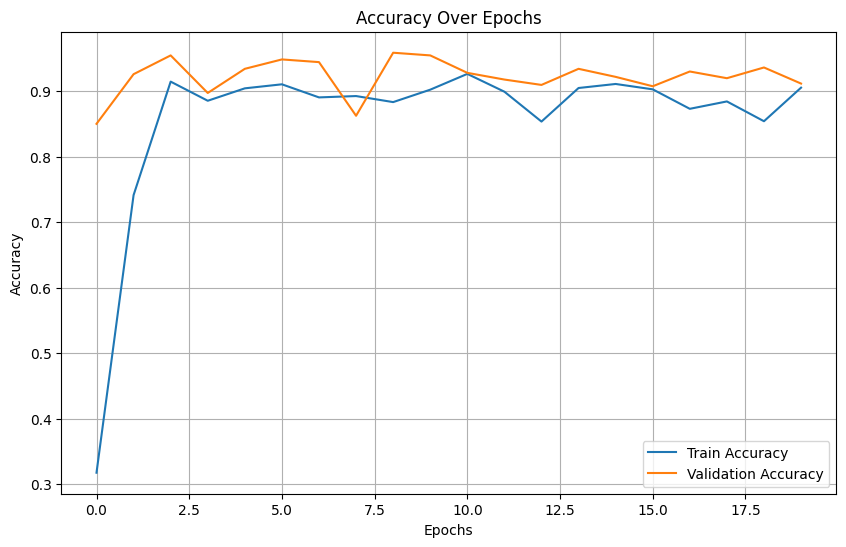

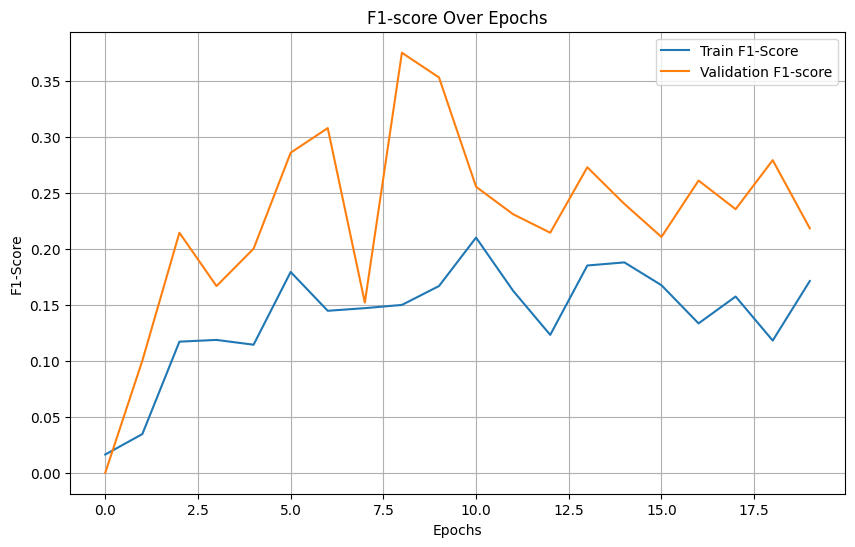

In [276]:
import matplotlib.pyplot as plt

# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Additional plots for other metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['f1_score'], label='Train F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-score Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [277]:
top.evaluate(test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9083 - auc: 0.9900 - auprc: 0.5589 - f1_score: 0.2571 - loss: 0.2561 - precision: 0.1482 - recall: 1.0000


[0.26151180267333984,
 0.9098360538482666,
 0.1269841343164444,
 1.0,
 0.9928363561630249,
 0.652962327003479,
 0.22535210847854614]

In [278]:
top.get_metrics_result()

{'accuracy': 0.9098360538482666,
 'auc': 0.9928363561630249,
 'auprc': 0.652962327003479,
 'f1_score': 0.22535210847854614,
 'loss': 0.26151180267333984,
 'precision': 0.1269841343164444,
 'recall': 1.0}